In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
%matplotlib inline

/home/mendyk/anaconda3/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
df=pd.read_csv('car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df=df.fillna(0)

In [5]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train,df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop =True)

In [7]:




# Remove target variable from features and create dictionaries
train_dict = df_train.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records')
val_dict = df_val.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records')
test_dict = df_test.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records')

# Create the DictVectorizer object and transform the data
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# Print shape to verify
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5822, 14)
X_val shape: (1941, 14)
X_test shape: (1941, 14)


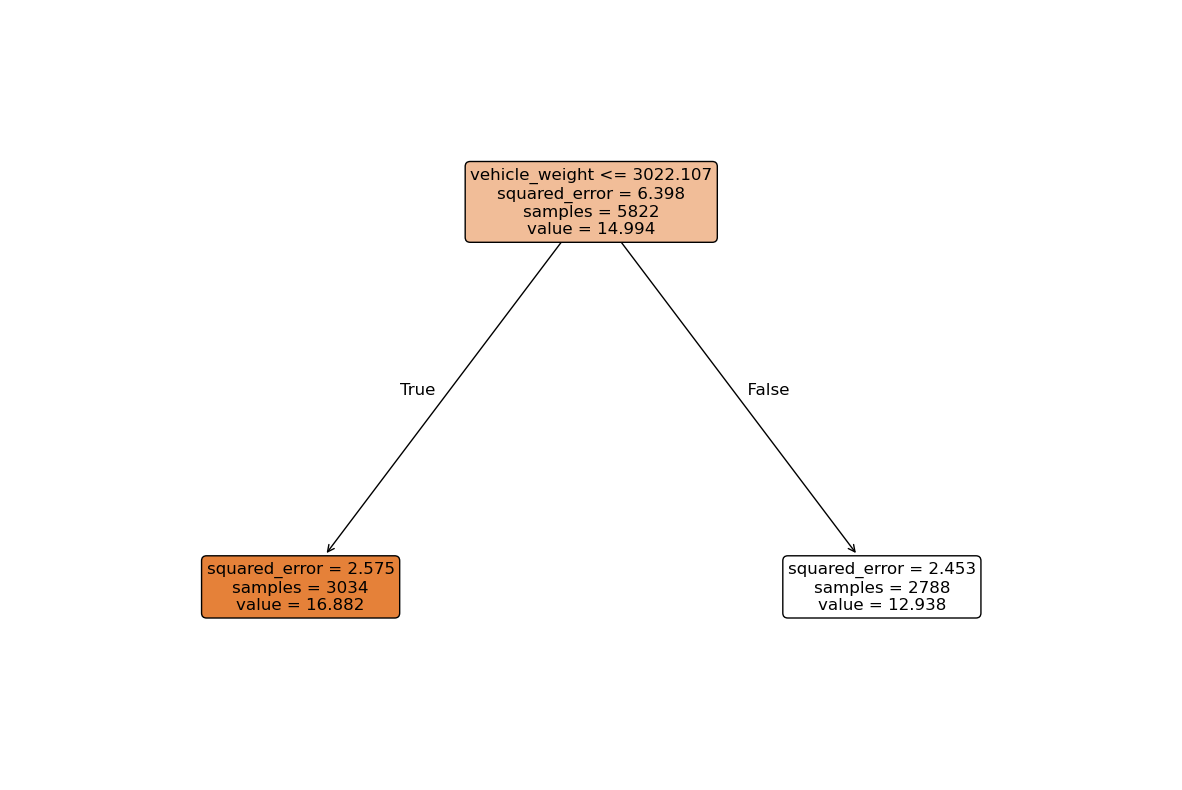


Feature Importances:
vehicle_weight: 1.0000


In [8]:
# Get target variable
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

# Train the decision tree with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Get feature names from DictVectorizer
feature_names = dv.get_feature_names_out()

# Plot the decision tree
plt.figure(figsize=(15,10))
plot_tree(dt, feature_names=feature_names, filled=True, rounded=True, fontsize=12)
plt.show()

# Print feature importances
print("\nFeature Importances:")
feature_importance = list(zip(feature_names, dt.feature_importances_))
for feature, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True):
    if importance > 0:
        print(f"{feature}: {importance:.4f}")

In [9]:
# Separate target from features
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values

X_train = dv.transform(df_train.drop(columns=['fuel_efficiency_mpg']).to_dict(orient='records'))
X_val   = dv.transform(df_val.drop(columns=['fuel_efficiency_mpg']).to_dict(orient='records'))

# Train model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_val)

# RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('rmse:', rmse)


rmse: 0.4595777223092726


In [ ]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores


In [ ]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Random Forest RMSE vs Number of Estimators')
plt.show()

In [ ]:
results = {}

for d in [10, 15, 20, 25]:
    scores = []
    
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            max_depth=d,
            n_estimators=n,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append(rmse)
    
    results[d] = np.mean(scores)

results


In [ ]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
for col, val in zip(dv.get_feature_names_out(), importances):
    print(col, val)


In [ ]:

# convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]


In [ ]:
xgb_params_03 = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'verbose_eval':5,
    'seed': 1,
    'verbosity': 1
}

model_03 = xgb.train(xgb_params_03, dtrain, num_boost_round=100, evals=watchlist)

y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))
print("RMSE (eta=0.3):", rmse_03)


In [ ]:
xgb_params_01 = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model_01 = xgb.train(xgb_params_01, dtrain, num_boost_round=100, evals=watchlist)

y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))
print("RMSE (eta=0.1):", rmse_01)
